In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv

Generating Mock Synthetic Data


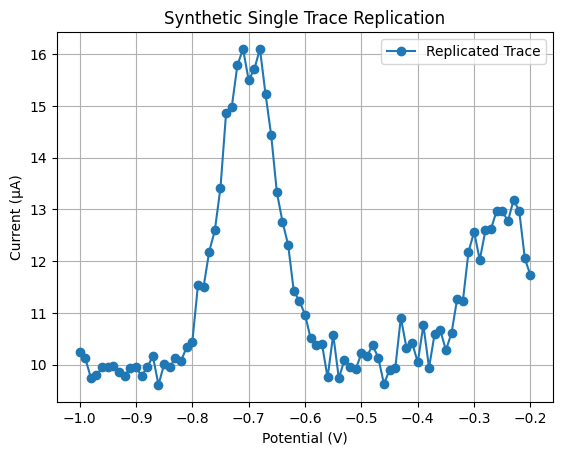

In [11]:
# 1) Generate synthetic data for one trace
#    We'll simulate two peaks plus a baseline and some random noise
def gaussian(x, amplitude, center, width):
    return amplitude * np.exp(-((x - center)**2) / (2 * width**2))

# Define the potential range (e.g., from -1.0 V to -0.2 V)
x = np.linspace(-1.0, -0.2, 81)  # 81 points in this range

# Baseline current (just a constant offset, 10 µA)
y_baseline = 10.0

# Define two Gaussian peaks (you can tweak these to change the shape)
peak1 = gaussian(x, amplitude=6.0,  center=-0.7,  width=0.05)   # smaller peak
peak2 = gaussian(x, amplitude=3.0, center=-0.25, width=0.06)   # larger peak

# Add some random noise for realism
noise = np.random.normal(loc=0.0, scale=0.3, size=len(x))

# Final current trace
y = y_baseline + peak1 + peak2 + noise

# 2) Write the synthetic data to a CSV file
csv_filename = "replicated_trace.csv"
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Potential (V)", "Current (µA)"])  # Header
    for xi, yi in zip(x, y):
        writer.writerow([xi, yi])

# 3) Read the data back from the CSV file
x_read = []
y_read = []
with open(csv_filename, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header
    for row in reader:
        x_read.append(float(row[0]))
        y_read.append(float(row[1]))

# 4) Plot the data from the CSV to confirm it looks correct
plt.plot(x_read, y_read, marker='o', linestyle='-', label='Replicated Trace')
plt.xlabel('Potential (V)')
plt.ylabel('Current (µA)')
plt.title('Synthetic Single Trace Replication')
plt.grid(True)
plt.legend()
plt.show()

Generating Mock Calibration Curve

   x (10^6 C/M) |  Line 1 (Ip, µA)   |  Line 2 (Ip, µA)
-----------------------------------------------------
          0.00 |            1.1028 |            2.2458
          0.50 |            6.2368 |            9.6808
          1.00 |           11.3708 |           17.1158
          1.50 |           16.5048 |           24.5508
          2.00 |           21.6388 |           31.9858
          2.50 |           26.7728 |           39.4208
          3.00 |           31.9068 |           46.8558
          3.50 |           37.0408 |           54.2908
          4.00 |           42.1748 |           61.7258


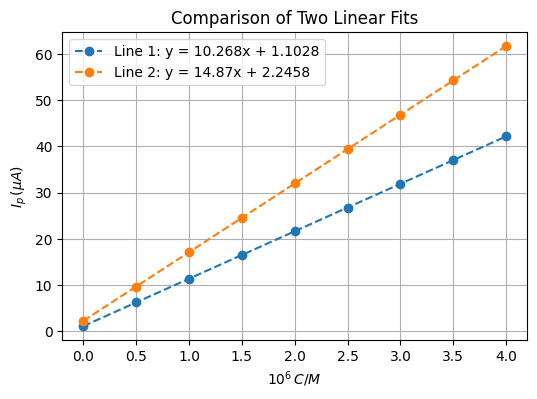

In [ ]:
# 1) Define the x-range you want (0 to 4, for example):
x = np.linspace(0, 4, 9)  # 9 points from 0 to 4 inclusive

# 2) Define the two lines (from the figure):
#    Line 2: y = 14.87x + 2.2458
#    Line 1: y = 10.268x + 1.1028
y_line2 = 14.87 * x + 2.2458
y_line1 = 10.268 * x + 1.1028

# 3) Create a table of values. Each row will be [x, y_line1, y_line2].
table = []
for xi, y1i, y2i in zip(x, y_line1, y_line2):
    table.append([xi, y1i, y2i])

# 4) Print the table in a neat format:
print("   x (10^6 C/M) |  Line 1 (Ip, µA)   |  Line 2 (Ip, µA)")
print("-----------------------------------------------------")
for row in table:
    print(f"{row[0]:14.2f} | {row[1]:17.4f} | {row[2]:17.4f}")

# 5) Plot both lines with Matplotlib:
plt.figure(figsize=(6,4))
plt.plot(x, y_line1, 'o--', label='Line 1: y = 10.268x + 1.1028')
plt.plot(x, y_line2, 'o--', label='Line 2: y = 14.87x + 2.2458')

plt.xlabel(r'$10^6 \, C/M$')
plt.ylabel(r'$I_p \, (\mu A)$')
plt.title('Calibration Curves')
plt.legend()
plt.grid(True)
plt.show()

Sample Concentration Estimation

Metal: Iron
  Peak Potential: -0.680 V
  Peak Current:   16.102 µA
  Estimated Concentration: 1.461 (arbitrary units)

Metal: Copper
  Peak Potential: -0.230 V
  Peak Current:   13.186 µA
  Estimated Concentration: 1.177 (arbitrary units)



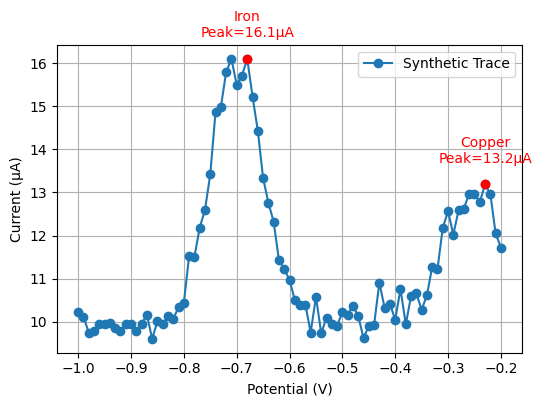

In [ ]:
metal = {
    "Iron"   : -0.7,
    "Copper" : -0.25
}
metal_search = 0.1  # +/- 0.1 V window around the known peak potential

#   y (µA) = slope * concentration + intercept
line1_slope = 10.268
line1_intercept = 1.1028

# We'll store results for each metal
results = []

for metal_name, center_potential in metal.items():
    lower_bound = center_potential - metal_search
    upper_bound = center_potential + metal_search

    # Extract data points in the search window
    v_window = []
    i_window = []
    for v_val, i_val in zip(v_data, i_data):
        if lower_bound <= v_val <= upper_bound:
            v_window.append(v_val)
            i_window.append(i_val)

    if not v_window:
        print(f"No data found in the window for {metal_name}.")
        continue

    # Find the index of maximum current in this window
    peak_idx = np.argmax(i_window)
    peak_potential = v_window[peak_idx]
    peak_current   = i_window[peak_idx]

    # 4) Use linear interpolation from the calibration to find concentration
    #    If y = slope * conc + intercept, then conc = (y - intercept)/slope
    estimated_concentration = (peak_current - line1_intercept) / line1_slope

    results.append((metal_name, peak_potential, peak_current, estimated_concentration))

# -------------------------------------------------------
# 5) Print results
# -------------------------------------------------------
for metal_name, p_pot, p_cur, conc in results:
    print(f"Metal: {metal_name}")
    print(f"  Peak Potential: {p_pot:.3f} V")
    print(f"  Peak Current:   {p_cur:.3f} µA")
    print(f"  Estimated Concentration: {conc:.3f} (arbitrary units)")
    print()

# -------------------------------------------------------
# 6) Plot the data to confirm
# -------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(v_data, i_data, label='Synthetic Trace', marker='o', linestyle='-')

# Mark the found peaks
for metal_name, p_pot, p_cur, conc in results:
    plt.plot(p_pot, p_cur, 'ro')
    plt.text(p_pot, p_cur + 0.5,
             f"{metal_name}\nPeak={p_cur:.1f}µA",
             ha='center', color='red')

plt.xlabel("Potential (V)")
plt.ylabel("Current (µA)")
plt.legend()
plt.grid(True)
plt.show()
